# Calculating Extreme Heat days using daily projections from Cal-Adapt API

This notebook walks you through how we calculate projected Extreme Heat Days for an area.

### Step 1. Download data
 - Download observed daily maximum temperatures for an area or grid cell.
 - Download projected daily maximum temperatures for the location. We will use the 4 priority models and RCP 8.5 scenario (HadGEM2-ES, CNRM-CM5, CanESM2, MIROC5 models have been selected by [California’s Climate Action Team Research Working Group](http://climatechange.ca.gov/climate_action_team/research.html) as [priority models for research](http://docketpublic.energy.ca.gov/PublicDocuments/16-IEPR-04/TN215798_20170207T111409_Projected_Climate_Scenarios_Selected_to_Represent_a_Range_of_Po.pdf) contributing to California’s Fourth Climate Change Assessment).
 
### Step 2. Calculate Extreme Heat Threshold
 - Using a baseline period of 1961 - 1990, calculate the 98th percentile value of all temperatures from April - October from the observed data.
 - This 98th percentile value is the Extreme Heat Threshold for that location (note: different locations will have different values for extreme heat threshold). If you want to find all days above a cutoff threshold temperature, e.g. 100F, you can skip this step. 

### Step 3. Calculate number of extreme heat days
 - Find all days with maximum temperatures above threshold from observed and projected data.
 
### Step 4. Report projected Extreme heat days
 - For reporting projected Extreme Heat day counts we reccommend using decadal or multi-decadal averages for future time periods.
 
### Step 5. Calculate and Report Heat Waves
 
You can modify this approach for your needs.

In [1]:
# A 'magic' command to display plots inline
%matplotlib inline

# Import all python modules. You need to run this cell for the other cells to work.
import requests 
import numpy as np
import pandas as pd
from datetime import datetime
import itertools
import matplotlib.pyplot as plt
import seaborn as sns

----
## Step 1. Download data
----

### 1a. Defining your area of interest

The `g` geometry parameter is used to download data for a point, line or polygon. Geometry can be written in various formats including WKT, GeoJSON, KML. The examples below use WKT (Well Known Text) format.

#### To get data for a grid cell ...

In [2]:
point = 'POINT(-121.4687 38.5938)'
params = {'g': point}

#### To get data for a user defined polygon ...

The `stat` parameter is used to spatially aggregation grid cell values intersected by the polygon/line geometry. Accepted values can be one of `mean`, `max`, `min`, `count`, `median`, `std`, `var`. If you don't provide the `stat` parameter the API will return an array of grid cell values.

You can create a new polygon using this [online WKT editor](https://arthur-e.github.io/Wicket/sandbox-gmaps3.html) or any GIS software.

In [3]:
polygon = 'POLYGON ((-123.35449 39.09596, -122.27783 39.09596, -122.27783 39.97712, -123.35449 39.97712, -123.35449 39.09596))' 
params = {'g': polygon, 'stat': 'mean'}

#### Or select a polygon from boundaries stored on Cal-Adapt

To use polygon geometry from Cal-Adapt API, it's a 2-step process

- Query a Cal-Adapt API boundary layer ([list of available boundaries](https://berkeley-gif.github.io/caladapt-docs/data-catalog.html#vector-data)) using a point to get the intersecting polygon
- Instead of passing the geometry using the `g` parameter, use the `ref` parameter to use geometry stored on server 

**Note: Requests might time out if the polygon is too large. Subsetting the daily data has been tested with polygons on scale of counties, census tracts, places and hydrounits. If you need data for a large boundary we reccomend downloading the daily rasters and processing the data locally.** 

In [4]:
# Cal-Adapt API
api = 'http://api.cal-adapt.org/api'
headers = {'ContentType': 'json'}

# Your point of interest
point = 'POINT(-121.4687 38.5938)'

# Name of boundary layer in API
resource = 'counties'

# Request url
url = api + '/' + resource + '/'
# Request params to find intersecting polygon
params = {'intersects': point, 'srs': 4326, 'simplify': .0001, 'precision': 4}
ref = ''
location = ''

# Get geometry
response = requests.get(url, params=params, headers=headers)
if response.ok:
    data = response.json()
    feature = data['features'][0]
    if (feature):
        ref = '/api/%s/%s/' % (resource, feature['id'])
        location = feature['properties']['name']
        print('ref =', ref)
        print('location =', location)
    else:
        print('Did not find any polygons that intersect your point')

params = {'ref': ref, 'stat': 'mean'}

ref = /api/counties/34/
location = Sacramento


### 1b. Download observed daily tasmax

Daily data is stored as a multiband raster, e.g. observed daily timeseries (1950 -2013) has 23376 bands with each band corresponding to one day, starting from 1950-01-01. Units for the observed data are degrees Celsius and projected data are in Kelvin.

The code in the next cell contains a bunch of functions to:
    - fetch daily data given a slug and params
    - convert units to degrees F
    - return a new Pandas dataframe that contains all the data

In [5]:
# Cal-Adapt API
api = 'http://api.cal-adapt.org/api'

# Request header
headers = {'ContentType': 'json'}

def celsius_to_F(val):
    return val * 9/5 + 32

def kelvin_to_F(val):
    return  (val - 273.15) * 9/5 + 32

def process_daily_data(slug, params):
    # Make request
    url = api + '/series/' + slug + '/rasters/'
    response = requests.get(url, params=params)
    
    # Get data
    if response.ok:
        print('Processing:', slug)
        json = response.json()
        data = json['results'][0]

        # Multiband raster data is returned by the API as a 3D array having a shape like (233376, 1, 1)
        # Flatten the 3D array into a 1D array
        values_arr = np.array(data['image'])
        values_arr = values_arr.flatten()

        # Get total number of values -> number of days
        length = len(values_arr)

        # Get start date of timeseries
        start_date = datetime.strptime(data['event'], '%Y-%m-%d')

        # Create new pandas dataframe and map each value in list to a date index
        df = pd.DataFrame(
            values_arr,
            index=pd.date_range(start_date, freq='1D', periods=length),
            columns=['value'],
        )

        # Convert units to Fahrenheit
        units = data['units']
        if units == 'C':
            df.value = df.value.apply(lambda x: celsius_to_F(x))
        elif units == 'K':
            df.value = df.value.apply(lambda x: kelvin_to_F(x))
        else:
            pass
            
        # Add slug as a column
        df['slug'] = slug  

    else:
        print('Failed to download:', slug)
            
    # Combine all the dataframes into one and return
    return df

In [6]:
def get_observed():
    # Create slug
    slug = 'tasmax_day_livneh'
    params = {'ref': ref, 'stat': 'mean'}
    df = process_daily_data(slug, params)
    return df

In [7]:
observedDF = get_observed()
observedDF

Processing: tasmax_day_livneh


,value,slug
1950-01-01,47.537341,tasmax_day_livneh
1950-01-02,43.417568,tasmax_day_livneh
1950-01-03,46.940557,tasmax_day_livneh
1950-01-04,43.705381,tasmax_day_livneh
1950-01-05,45.215155,tasmax_day_livneh
1950-01-06,48.405793,tasmax_day_livneh
1950-01-07,50.585093,tasmax_day_livneh
1950-01-08,50.540371,tasmax_day_livneh
1950-01-09,50.566721,tasmax_day_livneh
1950-01-10,49.278330,tasmax_day_livneh


### 1c. Download projected daily tasmax

The projected daily timeseries are form 2006 - 2099/2100 and units are in degrees Kelvin. You can easily modify the code to add/subtract models, scenarios, climate variables

In [154]:
def get_projections():
    # Create an empty list to hold dataframes
    df_list = []

    # Make a combined list of GCMs, scenarios, climate variables for looping
    climvar = ['tasmax']
    period = ['day']
    models = ['CanESM2', 'CNRM-CM5', 'HadGEM2-ES', 'MIROC5']
    #scenarios = ['rcp45', 'rcp85', 'historical]
    scenarios = ['rcp45', 'historical']
    zipped = itertools.product(climvar, period, models, scenarios)
    
    # Request parameters
    params = {'ref': ref, 'stat': 'mean'}

    # Loop through zipped
    for item in zipped:
        # Create slug
        slug = '_'.join(item)
        df = process_daily_data(slug, params)
        df_list.append(df)
            
    # Combine all the dataframes into one and return
    return pd.concat(df_list)

In [155]:
projectedDF = get_projections()
projectedDF

Processing: tasmax_day_CanESM2_rcp45
Processing: tasmax_day_CanESM2_historical
Processing: tasmax_day_CNRM-CM5_rcp45
Processing: tasmax_day_CNRM-CM5_historical
Processing: tasmax_day_HadGEM2-ES_rcp45
Processing: tasmax_day_HadGEM2-ES_historical
Processing: tasmax_day_MIROC5_rcp45
Processing: tasmax_day_MIROC5_historical


,value,slug
2006-01-01,47.327741,tasmax_day_CanESM2_rcp45
2006-01-02,46.656619,tasmax_day_CanESM2_rcp45
2006-01-03,49.182070,tasmax_day_CanESM2_rcp45
2006-01-04,48.421318,tasmax_day_CanESM2_rcp45
2006-01-05,47.873243,tasmax_day_CanESM2_rcp45
2006-01-06,48.280874,tasmax_day_CanESM2_rcp45
2006-01-07,48.614568,tasmax_day_CanESM2_rcp45
2006-01-08,46.020798,tasmax_day_CanESM2_rcp45
2006-01-09,50.324467,tasmax_day_CanESM2_rcp45
2006-01-10,52.452399,tasmax_day_CanESM2_rcp45


----
## Step 2. Calculate Extreme Heat threshold
----

For the Cal-Adapt Extreme Heat Tool, Extreme Heat Threshold is the 98th percentile of historical maximum temperatures between April 1 and October 31 based on observed daily temperature data from 1961–1990.

In [10]:
# Filter data by baseline time period
baselineDF = observedDF.loc['1961-01-01':'1990-12-31']

# Filter data by warm months
baselineDF = baselineDF[(baselineDF.index.month >= 4) & (baselineDF.index.month <= 10)]

print(baselineDF.head())
print()
print(baselineDF.tail())

                value               slug
1961-04-01  73.500947  tasmax_day_livneh
1961-04-02  78.862910  tasmax_day_livneh
1961-04-03  83.878230  tasmax_day_livneh
1961-04-04  83.873029  tasmax_day_livneh
1961-04-05  79.941237  tasmax_day_livneh

                value               slug
1990-10-27  83.352703  tasmax_day_livneh
1990-10-28  82.617298  tasmax_day_livneh
1990-10-29  77.272040  tasmax_day_livneh
1990-10-30  73.994929  tasmax_day_livneh
1990-10-31  71.551565  tasmax_day_livneh


In [11]:
threshold = baselineDF['value'].quantile(0.98, interpolation='linear')
print('Extreme Heat Threshold value for', location, 'is', round(threshold, 1), 'degrees Fahrenheit')

Extreme Heat Threshold value for Sacramento is 102.7 degrees Fahrenheit


----

## Step 3. Calculate number of extreme heat days
----

### 3a. Find number of extreme heat days from observed data

In [12]:
# Filter days > threshold
observed_heat_days = pd.DataFrame(observedDF[observedDF.value > threshold])
observed_heat_days['series'] = 'livneh'
observed_heat_days.index.name = 'date'
observed_heat_days = observed_heat_days.drop(['slug'], axis=1)

print(observed_heat_days.head())
print()
print(observed_heat_days.tail())

                 value  series
date                          
1950-06-29  104.639277  livneh
1950-06-30  108.364349  livneh
1950-07-01  109.104388  livneh
1950-07-02  108.365464  livneh
1950-07-03  106.242579  livneh

                 value  series
date                          
2013-06-30  104.372992  livneh
2013-07-01  104.587880  livneh
2013-07-02  103.628676  livneh
2013-07-03  103.471134  livneh
2013-07-04  106.828225  livneh


### 3b. Find number of extreme heat days from projected data

In [156]:
# Filter days > threshold
projected_heat_days = pd.DataFrame(projectedDF[projectedDF.value > threshold])
projected_heat_days['series'] = projected_heat_days['slug'].str.split('_', expand=True)[2]
projected_heat_days.index.name = 'date'
projected_heat_days = projected_heat_days.drop(['slug'], axis=1)

print(projected_heat_days.head())
print()
print(projected_heat_days.tail())

                 value   series
date                           
2006-05-29  103.778204  CanESM2
2006-05-30  105.844195  CanESM2
2006-05-31  103.090664  CanESM2
2006-06-25  106.293181  CanESM2
2006-06-26  106.189488  CanESM2

                 value  series
date                          
2003-08-02  103.096136  MIROC5
2003-08-03  104.731264  MIROC5
2003-08-04  103.864029  MIROC5
2003-08-05  103.420879  MIROC5
2005-08-03  102.936991  MIROC5


----
## Step 4.  Report projected Extreme heat days
----

### 4a. Count of extreme heat days by year averaged over baseline period

In [157]:
# Filter dates by baseline time period
baseline_heat_days = observed_heat_days.loc['1961-01-01':'1990-12-31']
# Group by year and calculate mean
count = baseline_heat_days.value.resample('1AS').count().mean()
print('Historically (1961-1990)', location, 'County had an average of', int(count), 'days with daily highs above', round(threshold, 1), 'degrees F')

Historically (1961-1990) Sacramento County had an average of 4 days with daily highs above 102.7 degrees F


### 4b. Projected count of extreme heat days by year averaged for 2070-2099

In [158]:
# Filter dates by end of century time period
century_end_heat_days = projected_heat_days.loc['2070-01-01':'2099-12-31']

In [159]:
heat_days = century_end_heat_days.loc[century_end_heat_days['series'] == 'HadGEM2-ES']
count = heat_days.value.resample('1AS').count().mean()
print('If current emission trends peak around 2040 and then decline (RCP 4.5)', location, 'County will have an average of', int(count), 'days with daily highs above', round(threshold, 1), 'degrees F by end of century (2070-2099) under simulated hot/dry conditions (HadGEM2-ES)')

If current emission trends peak around 2040 and then decline (RCP 4.5) Sacramento County will have an average of 33 days with daily highs above 102.7 degrees F by end of century (2070-2099) under simulated hot/dry conditions (HadGEM2-ES)


### 4c. Plot Number of Extreme Heat Days by Year

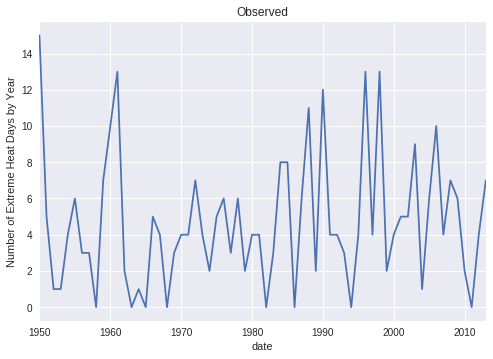

In [160]:
observed_count_by_year = observed_heat_days.value.resample('1AS').count()

# Plot
observed_count_by_year.plot()
plt.title("Observed")
plt.ylabel("Number of Extreme Heat Days by Year")

In [161]:
projected_count_by_year = projected_heat_days.groupby(['series']).value.resample('1AS').count().unstack('series')
projected_count_by_year

series,CNRM-CM5,CanESM2,HadGEM2-ES,MIROC5
date,,,,
1950-01-01,1.0,3.0,2.0,3.0
1951-01-01,3.0,5.0,3.0,12.0
1952-01-01,2.0,2.0,5.0,3.0
1953-01-01,3.0,1.0,10.0,1.0
1954-01-01,5.0,2.0,1.0,15.0
1955-01-01,4.0,5.0,0.0,2.0
1956-01-01,12.0,0.0,13.0,2.0
1957-01-01,1.0,0.0,11.0,7.0
1958-01-01,0.0,5.0,4.0,2.0


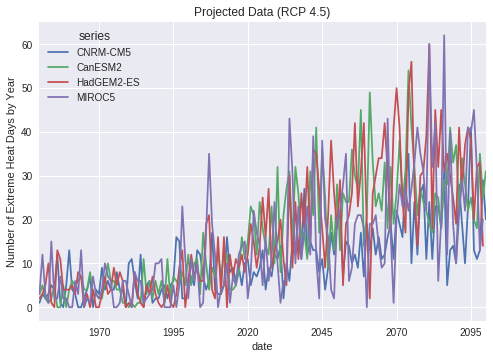

In [162]:
# Plot
projected_count_by_year.plot()
plt.title("Projected Data (RCP 4.5)")
plt.ylabel("Number of Extreme Heat Days by Year")


### 4d. Heatmap of Timing of Extreme Heat Days

In [163]:
months_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 
              7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

In [21]:
observed_count_by_month = pd.DataFrame(observed_heat_days.value.resample('M').count())
observed_count_by_month['month'] = observed_count_by_month.index.month
observed_count_by_month['year'] = observed_count_by_month.index.year
observed_count_by_month.rename(columns={'value': 'count'}, inplace=True)
#observed_count_by_month
observed_count_by_month_pivot = observed_count_by_month.pivot(index='month', columns='year', values='count')
observed_count_by_month_pivot.sort_index(ascending=False, inplace=True)
observed_count_by_month_pivot.fillna(0, inplace=True)
observed_count_by_month_pivot

year,1950,1951,1952,1953,1954,1955,1956,1957,1958,1959,...,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013
month,,,,,,,,,,,,,,,,,,,,,
12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,5.0,0.0,0.0,0.0,0.0,4.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,4.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,...,1.0,2.0,0.0,2.0,4.0,1.0,2.0,0.0,2.0,0.0
7,4.0,3.0,1.0,1.0,2.0,0.0,1.0,0.0,0.0,3.0,...,0.0,4.0,9.0,2.0,2.0,3.0,0.0,0.0,2.0,4.0
6,2.0,0.0,0.0,0.0,2.0,0.0,2.0,2.0,0.0,3.0,...,0.0,0.0,1.0,0.0,1.0,2.0,0.0,0.0,0.0,3.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


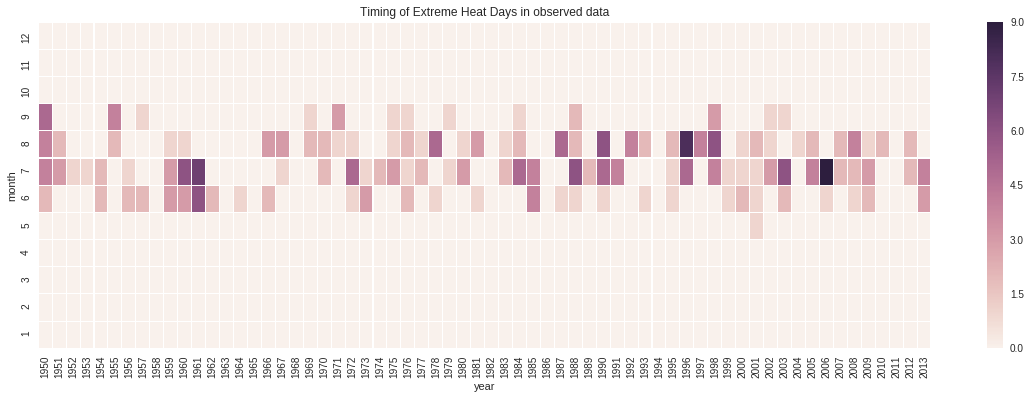

In [22]:
plt.figure(figsize=(20,6))
ax = sns.heatmap(observed_count_by_month_pivot, linewidth=0.1)
plt.title("Timing of Extreme Heat Days in observed data")
plt.show()

In [164]:
projected_count_by_month = projected_heat_days.groupby(['series']).value.resample('M').count().unstack('series')
projected_count_by_month['month'] = projected_count_by_month.index.month
projected_count_by_month['year'] = projected_count_by_month.index.year
projected_count_by_month.fillna(0, inplace=True)
projected_count_by_month

series,CNRM-CM5,CanESM2,HadGEM2-ES,MIROC5,month,year
date,,,,,,
1950-07-31,0.0,0.0,0.0,3.0,7,1950
1950-08-31,1.0,3.0,2.0,0.0,8,1950
1950-09-30,0.0,0.0,0.0,0.0,9,1950
1950-10-31,0.0,0.0,0.0,0.0,10,1950
1950-11-30,0.0,0.0,0.0,0.0,11,1950
1950-12-31,0.0,0.0,0.0,0.0,12,1950
1951-01-31,0.0,0.0,0.0,0.0,1,1951
1951-02-28,0.0,0.0,0.0,0.0,2,1951
1951-03-31,0.0,0.0,0.0,0.0,3,1951


In [165]:
cool_wet = projected_count_by_month.pivot(index='month', columns='year', values='CNRM-CM5').sort_index(ascending=False)
hot_dry = projected_count_by_month.pivot(index='month', columns='year', values='HadGEM2-ES').sort_index(ascending=False)
average = projected_count_by_month.pivot(index='month', columns='year', values='CanESM2').sort_index(ascending=False)
complement = projected_count_by_month.pivot(index='month', columns='year', values='MIROC5').sort_index(ascending=False)

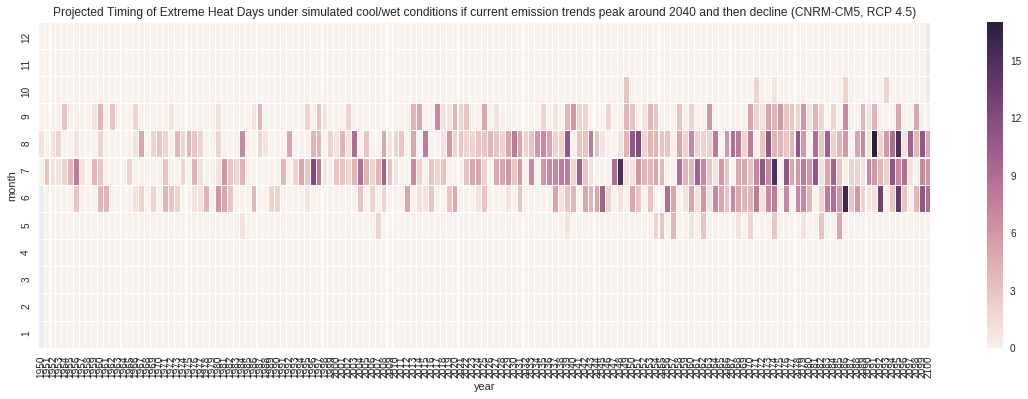

In [166]:
plt.figure(figsize=(20,6))
ax = sns.heatmap(cool_wet, linewidth=0.1)
plt.title("Projected Timing of Extreme Heat Days under simulated cool/wet conditions if current emission trends peak around 2040 and then decline (CNRM-CM5, RCP 4.5)")
plt.show()

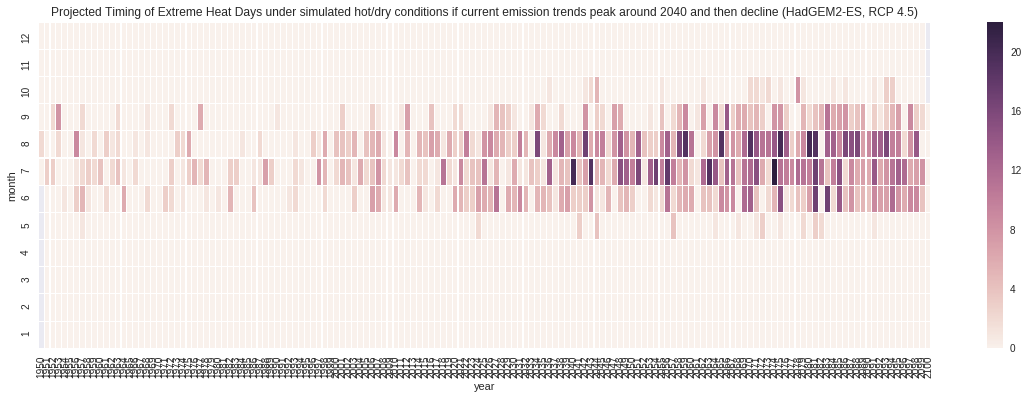

In [167]:
plt.figure(figsize=(20,6))
ax = sns.heatmap(hot_dry, linewidth=0.1)
plt.title("Projected Timing of Extreme Heat Days under simulated hot/dry conditions if current emission trends peak around 2040 and then decline (HadGEM2-ES, RCP 4.5)")
plt.show()

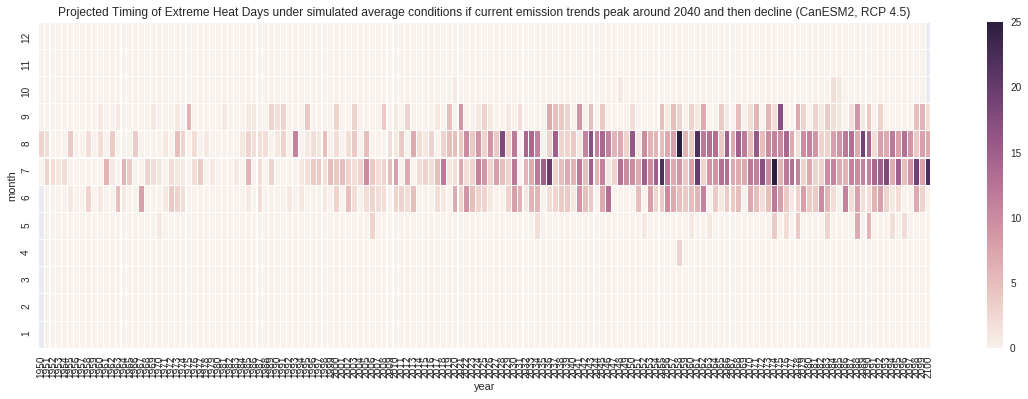

In [168]:
plt.figure(figsize=(20,6))
ax = sns.heatmap(average, linewidth=0.1)
plt.title("Projected Timing of Extreme Heat Days under simulated average conditions if current emission trends peak around 2040 and then decline (CanESM2, RCP 4.5)")
plt.show()

### 4e. Extreme Heat Days by Decade

In [169]:
observed_count_by_decade = pd.DataFrame(observed_heat_days.value.resample('1AS').count())
observed_count_by_decade = observed_count_by_decade.reset_index()
observed_count_by_decade['decade'] = observed_count_by_decade['date'].apply(lambda x: x.year//10*10)
observed_count_by_decade = observed_count_by_decade.groupby(['decade'])['value'].agg(['mean', 'min']).reset_index()
observed_count_by_decade['series'] = 'livneh'
observed_count_by_decade

,decade,mean,series
0,1950,4.50,livneh
1,1960,3.80,livneh
2,1970,4.30,livneh
3,1980,4.60,livneh
4,1990,5.90,livneh
5,2000,5.70,livneh
6,2010,3.25,livneh


In [170]:
projected_count_by_decade = pd.DataFrame(projected_heat_days.groupby(['series']).value.resample('1AS').count())
projected_count_by_decade = projected_count_by_decade.reset_index()
projected_count_by_decade['decade'] = projected_count_by_decade['date'].apply(lambda x: x.year//10*10)
projected_count_by_decade = projected_count_by_decade.groupby(['series', 'decade'])['value'].agg(['mean']).reset_index()
projected_count_by_decade

,series,decade,mean
0,CNRM-CM5,1950,3.6
1,CNRM-CM5,1960,3.7
2,CNRM-CM5,1970,4.6
3,CNRM-CM5,1980,5.5
4,CNRM-CM5,1990,5.9
5,CNRM-CM5,2000,7.9
6,CNRM-CM5,2010,7.4
7,CNRM-CM5,2020,8.5
8,CNRM-CM5,2030,12.3
9,CNRM-CM5,2040,11.4


In [210]:
decade = pd.concat([observed_count_by_decade, projected_count_by_decade])
decade = decade.drop(decade[(decade['series'] == 'livneh') & (decade['decade'] == 2010)].index)
decade = decade.drop(decade[(decade['series'] != 'livneh') & (decade['decade'] == 2000)].index)
decade = decade.drop(decade[(decade['series'] != 'livneh') & (decade['decade'] == 2100)].index)

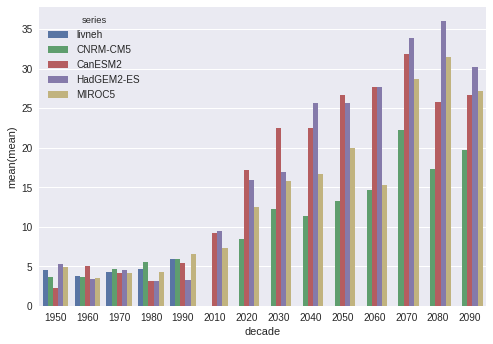

In [214]:
ax = sns.barplot(x='decade', y='mean', hue='series', data=decade)

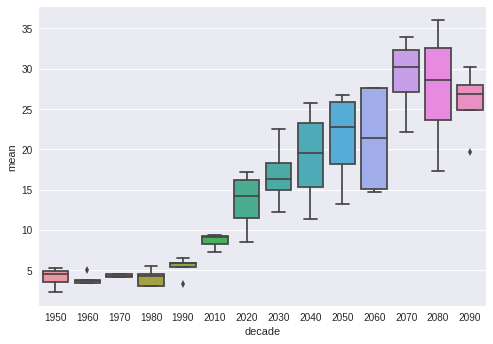

In [212]:
ax = sns.boxplot(x='decade', y='mean', data=decade)

----
## Step 5. Heat Waves
----

### 5a. Calculate Heat Waves

In [173]:
# This function takes a list of (date, value) tuples and groups consecutive dates together into lists
# Returns a list of lists

def parse_date_ranges(dates):

    def group_consecutive(dates):
        #dates_iter = iter(sorted(set(dates)))  # de-dup and sort
        dates_iter = iter(dates);

        run = [next(dates_iter)]
        for d in dates_iter:
            if (d[0].toordinal() - run[-1][0].toordinal()) == 1:  # consecutive?
                run.append(d)
            else:  # [start, end] of range else singleton
                yield [i for i in run]
                run = [d]

        #yield [run[0], run[-1]] if len(run) > 1 else run[0]
        yield [i for i in run]

    return list(group_consecutive(dates)) if dates else False

In [174]:
def calculate_heat_waves(df, period=3):
    # Convert dataframe rows into a list of tuples, each tuple has elements (date, temp, series)
    data = list(df.itertuples(index=True, name=None))
    
    # Rearrange list of tuples into list of arrays of consecutive dates
    data = parse_date_ranges(data)
    
    # Create a new dictionary to hold:
    #  1) count of heat waves by year
    #  2) max duration of heat wave by year
    #  3) avg temperature for max duration heatwave
    minYear = df.index.min().year
    maxYear = df.index.max().year
    heat_wave_by_year = dict.fromkeys(np.arange(minYear, (maxYear + 1), 1))
    for year in heat_wave_by_year:
        heat_wave_by_year[year] = { 'count':0, 'max_duration':0, 'max_duration_tavg':0, 'series':'' }
    
    # Number of extreme heat days that constitute a heat wave
    # How many heat waves if there is a 10 consecutive extreme heat days?
    # Count of heat waves = 10 // 3 (3 is the period that constitutes a heat wave)
    #                     = 3 (integer value of divisor)
    series_name = data[0][0][2]
    
    for item in data:
        duration = len(item)
        year = item[0][0].year # get year from datetime object
        temps = [x[1] for x in item]

        increment = duration // period
        heat_wave_by_year[year]['count'] += increment

        previous_max_duration = heat_wave_by_year[year]['max_duration']
        if (max(previous_max_duration, duration) == duration):
            heat_wave_by_year[year]['max_duration'] = duration
            heat_wave_by_year[year]['max_duration_tavg'] = sum(temps)/float(len(temps))
    
    # Convert dictionary back to Pandas Dataframe
    heat_wave_by_year_df = pd.DataFrame(heat_wave_by_year)
    heat_wave_by_year_df = heat_wave_by_year_df.transpose()
    heat_wave_by_year_df['series'] = series_name
    heat_wave_by_year_df = heat_wave_by_year_df.reset_index().rename(columns={'index':'year'})
    
    # Return new Pandas Dataframe
    return heat_wave_by_year_df

In [175]:
observed_hw = calculate_heat_waves(observed_heat_days)
cool_wet_hw = calculate_heat_waves(projected_heat_days.loc[projected_heat_days['series'] == 'CNRM-CM5'])
hot_dry_hw = calculate_heat_waves(projected_heat_days.loc[projected_heat_days['series'] == 'HadGEM2-ES'])
average_hw = calculate_heat_waves(projected_heat_days.loc[projected_heat_days['series'] == 'CanESM2'])
complement_hw = calculate_heat_waves(projected_heat_days.loc[projected_heat_days['series'] == 'MIROC5'])
heat_waves = pd.concat([observed_hw, cool_wet_hw, hot_dry_hw, average_hw, complement_hw])
heat_waves

,year,count,max_duration,max_duration_tavg,series
0,1950,3,5,107.677,livneh
1,1951,0,2,104.263,livneh
2,1952,0,1,103.84,livneh
3,1953,0,1,102.99,livneh
4,1954,0,2,105.563,livneh
5,1955,1,4,106.341,livneh
6,1956,0,2,105.683,livneh
7,1957,0,2,105.452,livneh
8,1958,0,0,0,livneh
9,1959,1,3,104.267,livneh


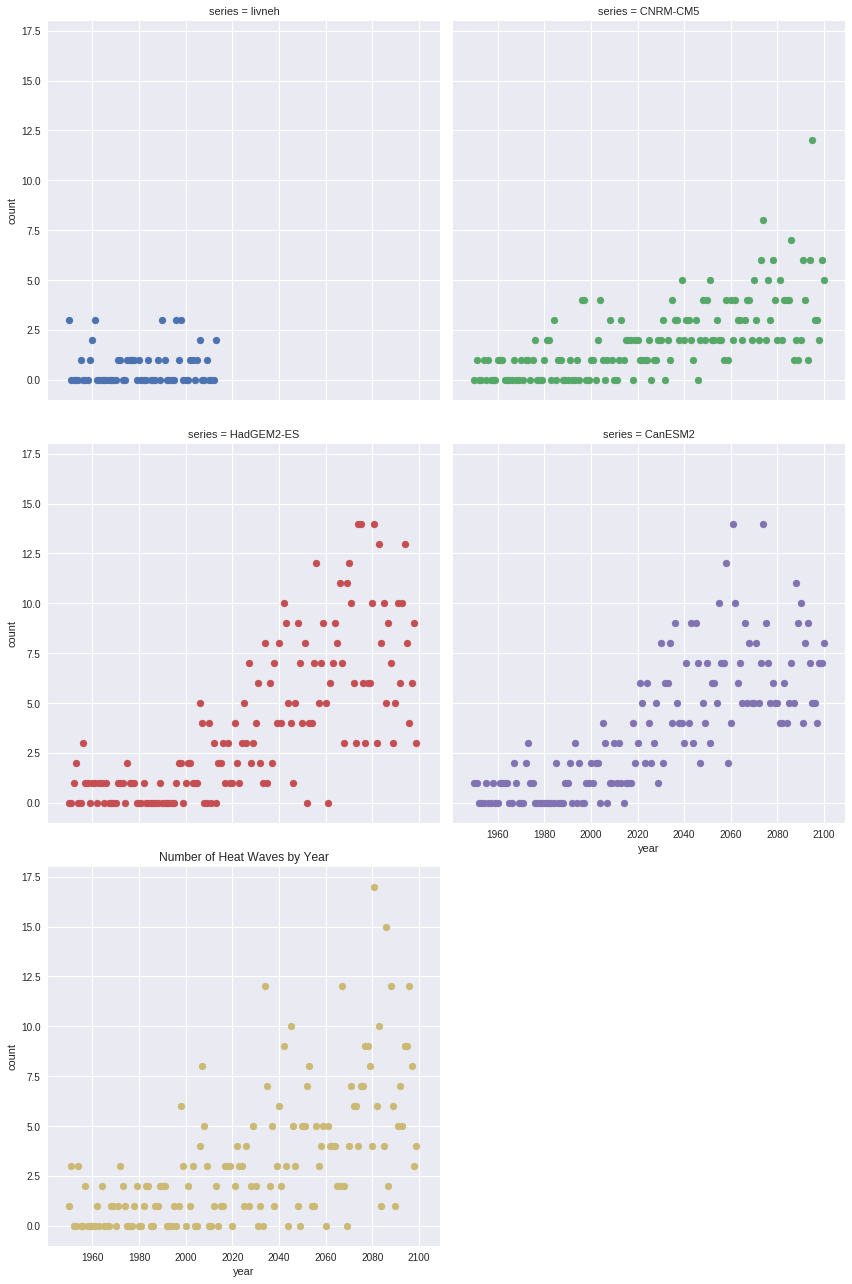

In [180]:
g = sns.FacetGrid(data=heat_waves, col='series', col_wrap=2, hue='series', size=6)
g.map(plt.scatter, 'year', 'count')

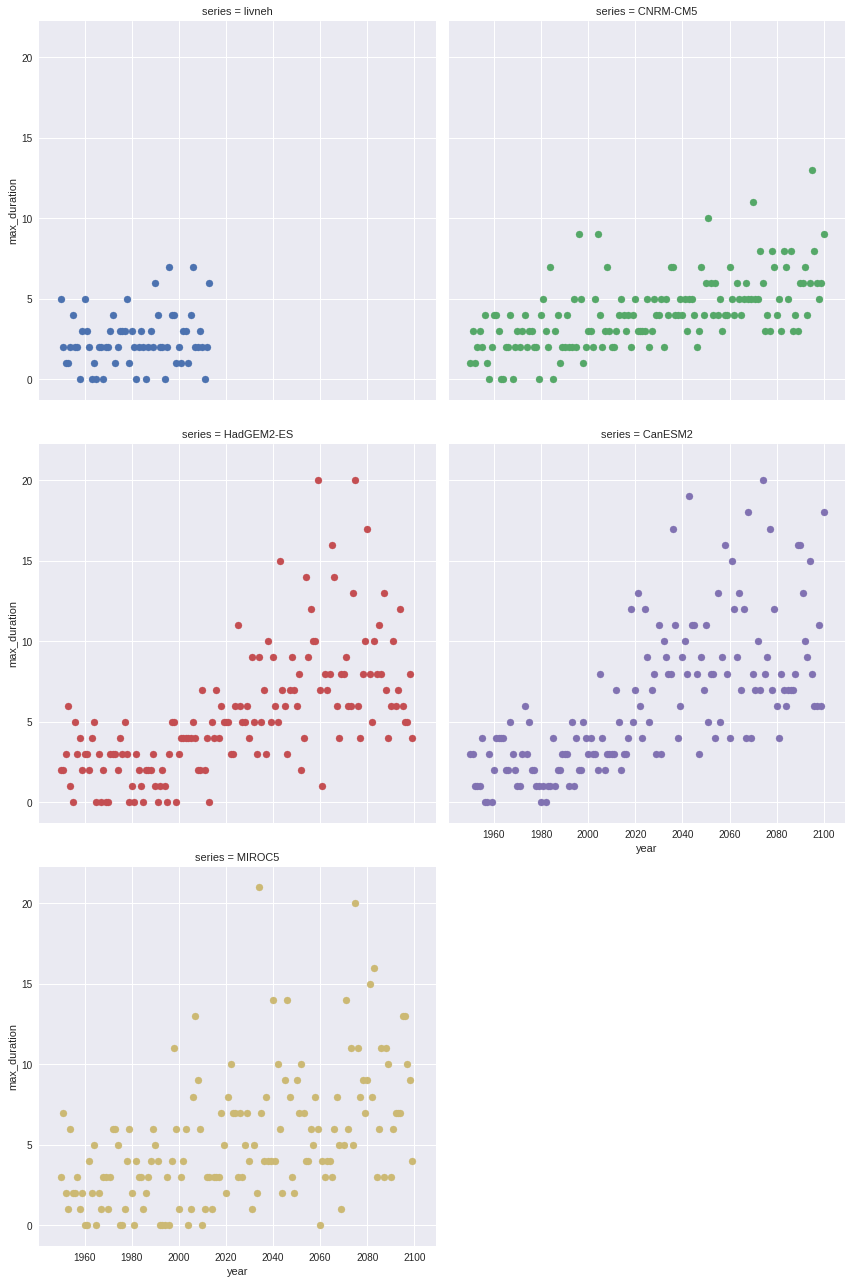

In [177]:
g = sns.FacetGrid(data=heat_waves, col='series', col_wrap=2, hue='series', size=6)
g.map(plt.scatter, 'year', 'max_duration')